In [29]:
import pandas as pd 
import numpy as np
import os, sys
import re
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from shared_functions.gg_sheet_drive import *

In [18]:
with open('D:/Study/Education/Projects/DataFlow/DataFlow_2026/data/autoscaling/train.txt', 'r') as f:
    lines = f.readlines()

In [4]:
lines[:10]

['199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245\n',
 'unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985\n',
 '199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085\n',
 'burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0\n',
 '199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179\n',
 'burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0" 304 0\n',
 'burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/video/livevideo.gif HTTP/1.0" 200 0\n',
 '205.212.115.106 - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/countdown.html HTTP/1.0" 200 3985\n',
 'd104.aa.net - - [01/Jul/1995:00:00:13 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985\n',
 '129.94.14

### Processing pipeline

In [ ]:
log_pattern = re.compile(
    r'(?P<ip>\S+)\s+'
    r'(?P<identd>\S+)\s+'
    r'(?P<user>\S+)\s+'
    r'\[(?P<time>[^\]]+)\]\s+'
    r'"(?P<request>[^"]*)"\s+'
    r'(?P<status>\d{3})\s+'
    r'(?P<size>\S+)'
)

def extract_info(line):
    match = log_pattern.match(line)
    if not match:
        return None

    d = match.groupdict()

    if d["request"]:
        parts = d["request"].split()
        d["resource"] = parts[1] if len(parts) > 1 else None
        d["protocol"] = parts[2] if len(parts) > 2 else None
    else:
        d["resource"] = d["protocol"] = None

    d["size"] = None if d["size"] == "-" else int(d["size"])
    d["status"] = int(d["status"])

    d['utc'] = f'UTC - {d['time'].split('-')[1][:2]}'

    d["time"] = pd.to_datetime(
        d["time"].split('-')[0].strip(), format="%d/%b/%Y:%H:%M:%S"
    )

    return d

In [ ]:
## Approach 1: Sequential processing

out_path = "parsed_logs.csv"
write_header = not os.path.exists(out_path)

df = pd.DataFrame(columns=extract_info(lines[0]).columns)

for line in tqdm(lines, desc="Parsing logs"):
    try:
        row = extract_info(line)     # 1-row DataFrame

        # append to csv immediately
        row.to_csv(out_path, mode="a", header=write_header, index=False)
        write_header = False

        # (optional) also keep in memory
        df = pd.concat([df, row], axis=0)

    except Exception as e:
        print(f"Error at line: {line}\n{e}")

df.reset_index(drop=True, inplace=True)


Parsing logs:   0%|          | 0/2934961 [00:00<?, ?it/s]C:\Users\admin\AppData\Local\Temp\ipykernel_15712\2484155689.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, row], axis=0)
Parsing logs:   1%|▏         | 39953/2934961 [06:53<9:53:38, 81.28it/s] 

This is slow due to 

1. pd.concat runs in O(n^2) time complexity
2. reset_index
3. stores everything in RAM

Change to batch streaming + dict instead of pd.df

In [ ]:
# Approach 2: Batch streaming

out_path = "parsed_logs2.csv"

fieldnames = list(extract_info(lines[0]).keys())

BATCH_SIZE = 50_000

# lines = lines[:]

with open(out_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()

    total = len(lines)

    for start in tqdm(range(0, total, BATCH_SIZE), desc="Batches"):
        end = min(start + BATCH_SIZE, total)
        batch = lines[start:end]

        buffer = []
        bad = 0

        for line in batch:
            try:
                d = extract_info(line)
                if d is not None:      
                    buffer.append(d)
                else:
                    bad += 1
            except Exception:
                bad += 1


        if buffer:
            writer.writerows(buffer)
            f.flush()
            os.fsync(f.fileno())

        print(f"Batch {start//BATCH_SIZE + 1}: "
              f"written {len(buffer)}, bad {bad}")


Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batch 1: written 50000, bad 0
Batch 2: written 50000, bad 0
Batch 3: written 49996, bad 4
Batch 4: written 50000, bad 0
Batch 5: written 50000, bad 0
Batch 6: written 50000, bad 0
Batch 7: written 50000, bad 0
Batch 8: written 50000, bad 0
Batch 9: written 50000, bad 0
Batch 10: written 50000, bad 0
Batch 11: written 49999, bad 1
Batch 12: written 50000, bad 0
Batch 13: written 50000, bad 0
Batch 14: written 50000, bad 0
Batch 15: written 50000, bad 0
Batch 16: written 50000, bad 0
Batch 17: written 49999, bad 1
Batch 18: written 50000, bad 0
Batch 19: written 50000, bad 0
Batch 20: written 50000, bad 0
Batch 21: written 49999, bad 1
Batch 22: written 49999, bad 1
Batch 23: written 49999, bad 1
Batch 24: written 50000, bad 0
Batch 25: written 50000, bad 0
Batch 26: written 49999, bad 1
Batch 27: written 50000, bad 0
Batch 28: written 49999, bad 1
Batch 29: written 50000, bad 0
Batch 30: written 50000, bad 0
Batch 31: written 49997, bad 3
Batch 32: written 50000, bad 0
Batch 33: written

### Start from here

In [ ]:
df = pd.read_csv("D:/Study/Education/Projects/DataFlow/DataFlow_2026/notebook/parsed_logs2.csv")

df['time'] = pd.to_datetime(df['time'])
df['status'] = df['status'].astype(int)
df['size'] = df['size'].astype(float)

In [36]:
df.shape

(2934932, 10)

In [ ]:
df.head(2)

,ip,identd,user,time,request,status,size,resource,protocol,utc
0,199.72.81.55,-,-,1995-07-01 00:00:01,GET /history/apollo/ HTTP/1.0,200,6245.0,/history/apollo/,HTTP/1.0,UTC - 04
1,unicomp6.unicomp.net,-,-,1995-07-01 00:00:06,GET /shuttle/countdown/ HTTP/1.0,200,3985.0,/shuttle/countdown/,HTTP/1.0,UTC - 04


(array([9312., 9319., 9326., 9333., 9343., 9350., 9357., 9364.]),
 [Text(9312.0, 0, '1995-07-01'),
  Text(9319.0, 0, '1995-07-08'),
  Text(9326.0, 0, '1995-07-15'),
  Text(9333.0, 0, '1995-07-22'),
  Text(9343.0, 0, '1995-08-01'),
  Text(9350.0, 0, '1995-08-08'),
  Text(9357.0, 0, '1995-08-15'),
  Text(9364.0, 0, '1995-08-22')])

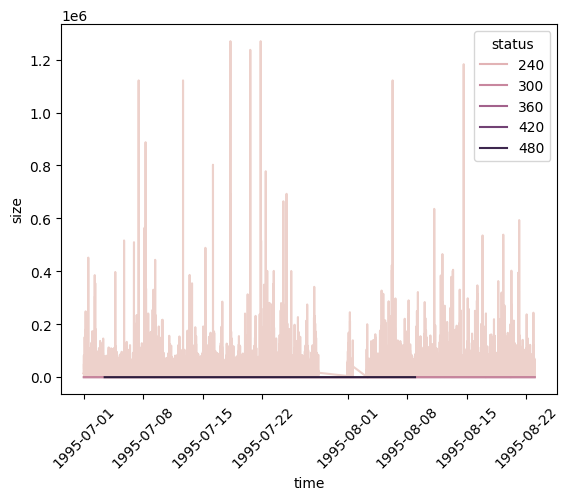

In [37]:
df["time"] = pd.to_datetime(df["time"])

df_agg = (
    df
    .set_index("time")
    .groupby("status")["size"]
    .resample("1min")      # or 1min, 5min, 15min, 1h
    .mean()
    .reset_index()
)

sns.lineplot(data=df_agg, x="time", y="size", hue="status")
plt.xticks(rotation=45)